# Preproccessing and loading data

In [1]:
from __future__ import print_function

from depmapomics.config import *

from depmapomics import loading, tracker
from depmapomics import mutations as omics_mut
from depmapomics import copynumbers as omics_cn
from genepy import terra
from genepy.utils import helper as h

import dalmatian as dm
from bokeh.plotting import output_notebook

%load_ext autoreload
%autoreload 2

output_notebook()

/Users/xiaomeng/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


No dataset version provided. Using version 98.
No dataset version provided. Using version 98.
No dataset version provided. Using version 98.


Loading BokehJS ...

## Adding new data

We are looking for new samples in a range of workspaces.

They are quite messy and might contains duplicates, contain broken file paths...

- We are thus looking at the bam files one by one and comparing them with our own bams. 
- We remove broken files, duplicates and add new version of a cell line's bam if we find some.

In [2]:
if isCCLE:
    print("loading new WGS data")
    wgssamples = loading.loadWGS(SAMPLESETNAME)

loading new WGS data
refsamples is overrided by a refurl
Getting sample infos...

The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager terra-broad-cancer-prod/DepMap_WGS>: (163, 233)
Identifying any true duplicates by checking file hashes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
listing files in gs
These 0 bam file path do not exist: set()
listing files in gs


/Users/xiaomeng/Desktop/cds/git/ccle_processing/depmapomics/loading.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples[extract['hash']] = [gcp.extractHash(val) for val in gcp.lsFiles(samples[extract["bam"]].tolist(), "-L", 200)]


listing files in gs


/Users/xiaomeng/Desktop/cds/git/ccle_processing/depmapomics/loading.py:343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples[extract['legacy_size']] = [gcp.extractSize(i)[1] for i in lis]
/Users/xiaomeng/Desktop/cds/git/ccle_processing/depmapomics/loading.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples[extract['update_time']] = [gcp.extractTime(i) for i in lis]


Index(['rna_ribosomal_bases', 'wgs_pct_80x', 'hs_zero_cvg_targets_pct',
       'min_insert_size', 'library-1_read_pair_duplicates',
       'hs_fold_enrichment', 'window_size', 'wgs_pct_100x',
       'rna_intergenic_bases', 'participant',
       ...
       'library-2_read_pairs_examined', 'library-2_name',
       'library-2_estimated_library_size', 'library-2_read_pair_duplicates',
       'crc32c_hash', 'legacy_size', 'update_time', 'sequencing_date',
       'participant_id', 'source'],
      dtype='object', length=238)
listing files in gs
listing files in gs
Index(['rna_ribosomal_bases', 'wgs_pct_80x', 'hs_zero_cvg_targets_pct',
       'min_insert_size', 'library-1_read_pair_duplicates',
       'hs_fold_enrichment', 'window_size', 'wgs_pct_100x',
       'rna_intergenic_bases', 'participant',
       ...
       'library-2_read_pairs_examined', 'library-2_name',
       'library-2_estimated_library_size', 'library-2_read_pair_duplicates',
       'crc32c_hash', 'legacy_size', 'update_time',

In [4]:
if isCCLE:
    ref = tracker.getCCLETracker()
    print('samples without wgs:')
    print(set(LINES_TO_RELEASE) - (set(wgssamples.arxspan_id) | set(ref[ref.datatype=='wgs'].arxspan_id)))
    print('\nsamples without DNAseq:')
    print(set(LINES_TO_RELEASE) - (set(wgssamples.arxspan_id) | set(ref[ref.datatype.isin(['wes', 'wgs'])].arxspan_id)))
    %store wgssamples

samples without wgs:
{'ACH-000205', '\n    "ACH-000345",\n    "ACH-000359",\n    "ACH-000399",\n    "ACH-000409",\n    "ACH-000515",\n    "ACH-000664",\n    "ACH-000744",\n    "ACH-000992",\n    "ACH-001032",\n    "ACH-001373",\n    "ACH-001393",\n    "ACH-001410",\n    "ACH-001558",\n    "ACH-001679",\n    "ACH-001696",\n    "ACH-002022",\n    "ACH-002060",\n    "ACH-002659",\n    "ACH-002687",\n    "ACH-002707",\n    '}

samples without DNAseq:
{'\n    "ACH-000345",\n    "ACH-000359",\n    "ACH-000399",\n    "ACH-000409",\n    "ACH-000515",\n    "ACH-000664",\n    "ACH-000744",\n    "ACH-000992",\n    "ACH-001032",\n    "ACH-001373",\n    "ACH-001393",\n    "ACH-001410",\n    "ACH-001558",\n    "ACH-001679",\n    "ACH-001696",\n    "ACH-002022",\n    "ACH-002060",\n    "ACH-002659",\n    "ACH-002687",\n    "ACH-002707",\n    '}
Stored 'wgssamples' (DataFrame)


In [ ]:
# HERE APPLY ANY STEP TO CLEANUP LINES FUTHER (from)
%store -r rnasamples
%store -r wgssamples
###############################
rnasamples.loc["CDS-nOdwML", 'participant_id'] = "PT-Elndt09g"
rnasamples.loc[["CDS-ugq3tZ",
"CDS-MyY7Gc"], 'cellosaurus_id'] = ["U", "CVCL_D843"]

wgssamples.loc[["CDS-WXSgfq",
"CDS-uLf8M0",
"CDS-5pxach",
"CDS-pX3bvG",
"CDS-JsZ9Nh",
"CDS-BXIBwR",
"CDS-BEbnKg",
"CDS-xvtYY4"],"cellosaurus_id"] = ["CVCL_D842",
"CVCL_D843",
"CVCL_0B81",
"CVCL_8915",
"CVCL_5040",
"CVCL_W891",
"CVCL_5402",
"CVCL_1793"]
#################################
%store rnasamples
%store wgssamples

In [ ]:
if isCCLE:
    print('sorting our patient_id for new samples on both WGS and RNAseq')
    %store -r rnasamples
    %store -r wgssamples
    for val in set(wgssamples.arxspan_id)&set(rnasamples.arxspan_id):
        r = rnasamples[rnasamples.arxspan_id == val] 
        w = wgssamples[wgssamples.arxspan_id == val]
        if len(set(r.participant_id) | set(w.participant_id)) >1:
            print("sorting out: "+val)
            v = r.participant_id[0]
            rnasamples.loc[r.index, 'participant_id'] = v
            wgssamples.loc[w.index, 'participant_id'] = v
    %store rnasamples
    %store wgssamples

In [6]:
wgssamples

,legacy_bam_filepath,legacy_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,legacy_size,PDO,update_time,datatype,...,primary_site,subtype,subsubtype,origin,parent_cell_line,matched_normal,comments,mediatype,condition,baits
sample_id,,,,,,,,,,,,,,,,,,,,,


In [ ]:
wgssamples = wgssamples[:3]

In [ ]:
if isCCLE:
    print("uploading samples to the tracker and Terra: "+SAMPLESETNAME)
    loading.update(wgssamples, samplesetname=SAMPLESETNAME, stype="wgs", bucket="gs://cclebams/wgs/", refworkspace=WGSWORKSPACE)

# run the pipeline

We are using Dalmatian to send request to Terra, we are running a set of 5 functions To generate the mutation dataset:

*   For new samples in DepMap, run the ICE version of this task. CCLE2 samples used Agilent targets, so this pipeline should be used instead. The pipelines are identical in terms of their outputs, but the proper targets, baits, and pseudo normal should be used based on how the samples were sequenced.

    **ICE_CGA_Production_Analysis_Pipeline_Cell_Lines_copy** (cclf/CGA_Production_Analysis_Pipeline_Cell_Lines_debuggingSnapshot ID: 22) OR


    **AGILENT_CGA_Production_Analysis_Pipeline_Cell_Lines** (cclf/CGA_Production_Anablysis_Pipeline_Cell_Lines_debuggingSnapshot ID: 22)

*   **common_variant_filter** (breardon/common_variant_filterSnapshot ID: 3)
*   **filterMAF_on_CGA_pipeline** (gkugener/filterMAF_on_CGA_pipelineSnapshot ID: 8)
*   **aggregateMAFs_selectFields** (ccle_mg/aggregateMAFs_selectFieldsSnapshot ID: 1)

This outputs to be downloaded will be saved in the sample set that was run. The output we use for the release is:


*   **passedCGA_filteredMAF_aggregated** 

There are several other tasks in this workspace. In brief:



*   **CGA_Production_Analysis_Pipeline_Cell_Lines** (lelagina/CGA_Production_Analysis_Pipeline_Cell_LinesSnapshot ID: 12). This task is the same as the ICE and AGILENT prefixed version above, except that it relied on pulling the baits and targets to use from the metadata stored for the samples. Having AGILENT and ICE versions specified made the uploading and running process easier.
*   **SANGER_CGA_Production_Analysis_Pipeline_Cell_Lines** (cclf/CGA_Production_Analysis_Pipeline_Cell_Lines_debuggingSnapshot ID: 22). This task was trying to run the CGA pipeline on the Sanger WES data, using a Sanger pseudo normal. In its current implementation, this task fails to complete for the samples.
*   **UNFILTERED_aggregateMAFs_selectFields** (ccle_mg/aggregateMAFs_selectFieldsSnapshot ID: 1). Aggregates the MAF outputted by the CGA cell line pipeline prior to the common variant filter and germline filtering tasks. This can give us insight to which mutations are getting filtered out when. We may want to potentially include this MAF in the release so people can see why certain mutations of interest may be getting filtered out.
*   WES_DM_Mutation_Calling_Pipeline_(standard |expensive) (gkugener/WES_DM_Mutation_Calling_PipelineSnapshot ID: 2). This was a previous mutation calling pipeline implemented for CCLE. We do not use this pipeline any more as the CGA pipeline looks better.
*   aggregate_filterMAF_CGA (CCLE/aggregate_filterMAF_CGASnapshot ID: 1). An aggregation MAF task that we used in the past. We do not use this task anymore.
*   calculate_mutational_burden (breardon/calculate_mutational_burdenSnapshot ID: 21). This task can be used to calculate the mutational rate of the samples. We do not make use of this data in the release although it could be of interest.
*   summarizeWigFile (breardon/summarizeWigFileSnapshot ID: 5). CCLF ran this task (might be necessary for the mutational burden task). For our workflow, we do not run it.

### cleaning workspaces

In [ ]:
doCleanup=True

In [ ]:
if doCleanup:
    print("cleaning workspaces")
    torm = await terra.deleteHeavyFiles(WGSWORKSPACE)
    h.parrun(['gsutil rm '+i for i in torm], cores=8)
    terra.removeFromFailedWorkflows(WGSWORKSPACE, dryrun=False, everythingFor=['Realign_WES_GATK4','Generate_uBAM_File_List','BamToUnmappedRGBams_MC','CGA_WES_CCLE_ICE','CGA_WES_CCLE_AGILENT'])

## On Terra

In [ ]:
# TODO: update with latest workspace parameters from our repo

In [ ]:
print("running Terra pipeline")
refwm = dm.WorkspaceManager(WGSWORKSPACE)
submission_id = refwm.create_submission("WGS_pipeline", SAMPLESETNAME, 'sample_set', expression='this.samples')
await terra.waitForSubmission(WGSWORKSPACE, submission_id)

In [ ]:
submission_id = refwm.create_submission("WGS_aggregate", 'all')
await terra.waitForSubmission(WGSWORKSPACE, submission_id)

### Save the workflow configurations used

In [ ]:
terra.saveWorkspace(WGSWORKSPACE,'data/'+SAMPLESETNAME+'/WGSconfig/')

## On local


### Copy Number

In [24]:
column_names = ["a", "b", "c"]

df = pd.DataFrame(columns = column_names)

df.loc[0, 'd'] = 1

df.d

/Users/xiaomeng/Desktop/cds/git/ccle_processing/depmapomics/copynumbers.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if prevgenecn is 'ccle':


No dataset version provided. Using version 98.
No dataset version provided. Using version 98.
No dataset version provided. Using version 98.


0    1.0
Name: d, dtype: float64

/Users/xiaomeng/Desktop/cds/git/ccle_processing/depmapomics/copynumbers.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if prevgenecn is 'ccle':


No dataset version provided. Using version 98.
No dataset version provided. Using version 98.
No dataset version provided. Using version 98.
new
No dataset version provided. Using version 98.
temp/21Q3/wes_
doing wgs
loading CN from Terra
cleaning up
loading 474 rows
making gene level copy number
downloading gene names from biomart


/Users/xiaomeng/Desktop/cds/git/ccle_processing/depmapomics/utils.py:45: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  res = _fetchFromServer(ensemble_server, attributes)


summary of the gene cn data:
4.903541350327266e-11 1.0634719361243576 1064.0077914372564
CDS-ovDo8V 2381
CDS-dIijHP 2193
CDS-AqZLna 2152
failed our QC
['CDS-ovDo8V', 'CDS-dIijHP', 'CDS-AqZLna']
saving files
done
removed 1 duplicate samples
could replace:
0
renaming
comparing to previous version
FOUND missmatch Columns NOT IN df2: {'LINC02606 (100506022)', 'ARPIN-AP3S2 (100526783)', 'AL359538.3 (105370295)', 'SNORA11E (101340250)', 'TAFA1 (407738)', 'LINC02808 (105378712)', 'MAPK10-AS1 (101929064)', 'DIPK1C (125704)', 'AL023755.1 (101928565)', 'AL589787.1 (728158)', 'AC007098.1 (100132215)', 'AL445433.2 (100129620)', 'LINC02023 (101928405)', 'AC093627.2 (105375115)', 'CBSL (102724560)', 'LINC02771 (105372907)', 'TSBP1 (10665)', 'TLCD5 (219902)', 'RPP38-DT (221060)', 'AC010618.3 (100507551)', 'CNTFR-AS1 (105376023)', 'AC013401.1 (112268441)', 'GOLGA8J (653073)', 'AC016987.2 (105370954)', 'AC016168.2 (105371899)', 'AC140504.1 (255027)', 'LINC02802 (645166)', 'AL591379.1 (100996643)', 'AL5

TypeError: object tuple can't be used in 'await' expression

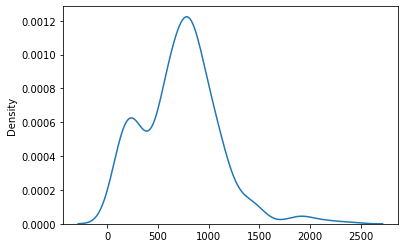

In [28]:
wespriosegs, wgspriosegs = await omics_cn.CCLEPostProcessing(samplesetname=SAMPLESETNAME)

### Achilles CN

In [ ]:
omics_cn.ProcessForAchilles(wespriosegs, wgspriosegs, samplesetname=SAMPLESETNAME,)

### Somatic Mutations

In [2]:
await omics_mut.CCLEPostProcessing(samplesetname=SAMPLESETNAME)

No dataset version provided. Using version 98.
doing wes
loading from Terra


/Users/xiaomeng/miniconda3/lib/python3.9/site-packages/dalmatian/wmanager.py:1144: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.io.json.json_normalize(r)
/Users/xiaomeng/Desktop/cds/git/ccle_processing/depmapomics/mutations.py:176: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  wesmutations = postProcess(wesrefworkspace, AllSamplesetName if AllSamplesetName else samplesetname,


done
renaming
doing wgs
loading from Terra


/Users/xiaomeng/miniconda3/lib/python3.9/site-packages/dalmatian/wmanager.py:1144: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.io.json.json_normalize(r)


done
renaming
merging


In [ ]:
await omics_mut.analyzeUnfiltered(allsampleset="allcurrent")

<coroutine object analyzeUnfiltered at 0x7ff694995040>

### Structural variants

### germline Mutations